# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuronal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la probabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import numpy as np
import torch
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain
from tqdm.notebook import tqdm as nbtqdm
from tqdm.auto import tqdm

In [2]:
# Definición de constantes
SEED = 420
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU: ngpu = 1
# CPU: ngpu = 0
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Paso 1. Limpieza de corpus

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', 'maner', 'y', 'se', 'le', 'mov', 'el', 'pal']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm']
  ['le', 'dig', 'pues', 'que', 'no', 'es', 'tu', 'tambor', 'le', 'dig']
  ['com', 'tambien', 'se', 'llen', 'de', 'agu']
  ['juan', 'se', 'cay', 'del', 'tech']
  ['sobr', 'un', 'refresquit', 'y', 'algo', 'de', 'vinit']


Muestro la curva de zipf

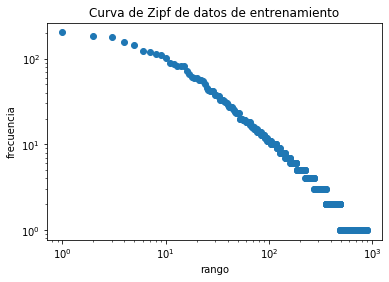

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [6]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal']


### Paso 2. <BOS\> <EOS\>

Insertar símbolos de inicio y final de cadena.

In [7]:
train_corpus_unk = list(map(lambda doc: [BOS, *doc, EOS], train_corpus_unk))
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej', '<EOS>']
['<BOS>', 'hem', 'fabric', 'un', 'temascal', 'par', 'bañ', '<EOS>']
['<BOS>', 'ni', 'par', 'el', 'jabon', 'encontr', '<EOS>']
['<BOS>', 'mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur', '<EOS>']
['<BOS>', 'se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal', '<EOS>']


### Paso 3. Indexar bigramas

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [8]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  per : 1
  pues : 2
  si : 3
  el : 4
  padr : 5
  del : 6
  hombr : 7
  quer : 8
  lo : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  [0, 14, 15, 16, 17, 18, 19, 13]
  [0, 20, 18, 4, 21, 22, 13]
  [0, 23, 24, 25, 26, 27, 28, 29, 13]
  [0, 30, 31, 32, 33, 34, 35, 30, 36, 37, 4, 38, 13]
  [0, 39, 40, 41, 42, 18, 43, 13]


Calculo el inverso del vocabulario, para obtener la palabra dado el índice.

In [9]:
inv_vocab = { item : key for key, item in vocab.items()}

```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [10]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'per'),
 ('per', 'pues'),
 ('pues', 'si'),
 ('si', 'el'),
 ('el', 'padr'),
 ('padr', 'del'),
 ('del', 'hombr'),
 ('hombr', 'quer'),
 ('quer', 'lo'),
 ('lo', 'iba'),
 ('iba', 'a'),
 ('a', 'dej'),
 ('dej', '<EOS>'),
 ('<BOS>', 'hem'),
 ('hem', 'fabric'),
 ('fabric', 'un'),
 ('un', 'temascal'),
 ('temascal', 'par'),
 ('par', 'bañ'),
 ('bañ', '<EOS>')]

Imprimo algunos de los bigramas más comunes en el corpus

In [11]:
counter_bigramas = Counter(bigramas)
counter_bigramas.most_common(15)

[(('<unk>', '<EOS>'), 114),
 (('<BOS>', 'pues'), 88),
 (('otra', 'vez'), 45),
 (('<BOS>', 'y'), 42),
 (('<BOS>', 'per'), 38),
 (('entonc', '<EOS>'), 36),
 (('<BOS>', 'se'), 35),
 (('el', '<unk>'), 29),
 (('nomas', '<EOS>'), 27),
 (('se', '<unk>'), 26),
 (('en', 'la'), 26),
 (('<BOS>', 'despues'), 25),
 (('<BOS>', 'no'), 25),
 (('<BOS>', 'lueg'), 25),
 (('par', 'que'), 25)]

In [12]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (0, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 13)]

### Paso 4. Modelo Neuronal

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).

In [13]:
# Hiperparámetros
d = 100# 100
m = 300# 300
epochs = 30
lr = 0.01

# Constantes
N = len(vocab)
print('Tamaño del vocabulario: ', N)

Tamaño del vocabulario:  493


In [14]:
C = torch.rand((d, N), dtype=torch.double, device=device)/np.sqrt(N)
W = torch.rand((m, d), dtype=torch.double, device=device)/np.sqrt(d)
b = torch.rand(m, dtype=torch.double, device=device)
U = torch.rand((N, m), dtype=torch.double, device=device)/np.sqrt(m)
c = torch.rand(N, dtype=torch.double, device=device)

In [15]:
h_i = torch.tanh(torch.matmul(W, C.T[0]) + b) # Segunda capa oculta
a = torch.matmul(U, h_i) + c # Preactivación
exp_a = torch.exp(a - a.max()) # Exponencial de la preactivación
prob_salida = exp_a/exp_a.sum() # Capa de salida softmax

In [18]:
y_pred = torch.argmax(prob_salida) # El índice de la palabra que predijo

# Backprop
# Copio el arreglo para no modificar pesos de la salida original
d_out = prob_salida.clone()
d_out[2] -= 1  # p(w_k | w_i) - y_k
d_h = (1-h_i**2)*(d_out.T @ U)
d_c = d_h.T @ W

In [33]:
(d_h.view(m, 1) @ C.T[0].view(1,d)).size()

torch.Size([300, 100])

In [45]:
prueba_tensor = torch.rand(4, dtype=torch.double, device=device)

In [46]:
print(prueba_tensor)
prueba_tensor[0].add_(-1)
print(prueba_tensor)

tensor([0.3961, 0.0738, 0.9925, 0.0919], device='cuda:0', dtype=torch.float64)
tensor([-0.6039,  0.0738,  0.9925,  0.0919], device='cuda:0',
       dtype=torch.float64)


#### Definición del modelo

Defino la matriz de la primer capa oculta (embedding). $ C \in \mathbb{R}^{d \times N} $.

In [42]:
class Bengio2003:
    def __init__(self, bigramas, d, m, N):
        self.d = d
        self.m = m
        self.N = N
        self.bigramas = bigramas

    def inicializar_pesos(self, device):
        self.C = torch.rand((self.d, self.N), dtype=torch.double, device=device)/np.sqrt(N)
        self.W = torch.rand((self.m, self.d), dtype=torch.double, device=device)/np.sqrt(d)
        self.b = torch.rand(self.m, dtype=torch.double, device=device)
        self.U = torch.rand((self.N, self.m), dtype=torch.double, device=device)/np.sqrt(m)
        self.c = torch.rand(self.N, dtype=torch.double, device=device)
    
    def forward(self, i_x):
        # La capa embedding se reduce a C_1[:, i_x]
        h_i = torch.tanh(torch.matmul(self.W, self.C.T[i_x]) + self.b) # Segunda capa oculta
        a = torch.matmul(self.U, h_i) + self.c # Preactivación
        exp_a = torch.exp(a - a.max()) # Exponencial de la preactivación
        prob_salida = exp_a/exp_a.sum() # Capa de salida softmax
        return (prob_salida, h_i)

    def backprop(self, i_x, i_y, prob_salida, h_i, lr=0.1):
        y_pred = torch.argmax(prob_salida) # El índice de la palabra que predijo
        
        # Backprop
        # Copio el arreglo para no modificar pesos de la salida original
        d_out = prob_salida.clone()
        d_out[i_y].add_(-1.0)  # p(w_k | w_i) - y_k
        d_h = (1-h_i**2)*(d_out.T @ self.U)
        d_c = d_h.T @ self.W
        
        # Optimizador Adam
        

        # Actualizamos los pesos
        self.U -= lr*(d_out.view(self.N, 1) @ h_i.view(1, self.m)) 
        self.c -= lr*d_out
        self.W -= lr*(d_h.view(m, 1) @ C.T[0].view(1,d)) 
        self.b -= lr*d_h
        self.C.T[i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0

    def predecir(self, i_x):
        return np.argmax(self.forward(i_x)[0])
    
    def entrenar(self, epochs=50, lr=0.1):
        entr_timeline = []
        for epoch in nbtqdm(range(epochs)):
            np.random.shuffle(bigramas)
            cross_entropy = 0
            for bigrama in self.bigramas:
                i_x = bigrama[0] # El índice de la primer palabra del bigrama
                i_y = bigrama[1] # El índice de la segunda palabra del bigrama
                # print(f'  Bigrama: {inv_vocab[i_x]} {inv_vocab[i_y]}')
                prob_salida, h_i = self.forward(i_x)
                # print(f'  Predicción: {inv_vocab[i_x]} {inv_vocab[np.argmax(prob_salida)]}')
                self.backprop(i_x, i_y, prob_salida, h_i)
                cross_entropy -= torch.log(prob_salida[i_y])
            entr_timeline.append(cross_entropy)
            tqdm.write(f'Epoch: {epoch+1} \tEntropía cruzada: {cross_entropy}')
        return entr_timeline
    
    def guardar_pesos(self, archivo):
        """Guarda los pesos del modelo en formato .npz
        """
        try:
            torch.savez(
                archivo, 
                C = self.C, 
                W = self.W, 
                b = self.b, 
                U = self.U, 
                c = self.c
            )
            print(f'Archivo {archivo} guardado satisfactoriamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
    
    def cargar_pesos(self, archivo):
        """Carga los pesos del modelo guardados en un archivo formato .npz
        """
        try:
            pesos = np.load(archivo)
            self.C = pesos['C']
            self.W = pesos['W']
            self.b = pesos['b']
            self.U = pesos['U']
            self.c = pesos['c']
            print(f'Pesos desde {archivo} cargados correctamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
        

In [43]:
modelo = Bengio2003(bigramas_ids, d, m, N)
modelo.inicializar_pesos(device)
hist_entropia = modelo.entrenar(epochs, lr=lr)

Epoch: 1 	Entropía cruzada: 34871.8780025535
Epoch: 2 	Entropía cruzada: 32470.329043943806
Epoch: 3 	Entropía cruzada: 31011.49436268708
Epoch: 4 	Entropía cruzada: 29761.25486056886
Epoch: 5 	Entropía cruzada: 28787.20237114563
Epoch: 6 	Entropía cruzada: 27979.450596321585
Epoch: 7 	Entropía cruzada: 27300.77252251553
Epoch: 8 	Entropía cruzada: 26695.22418157064
Epoch: 9 	Entropía cruzada: 26148.432174081267
Epoch: 10 	Entropía cruzada: 25653.874628708927
Epoch: 11 	Entropía cruzada: 25222.899373558677
Epoch: 12 	Entropía cruzada: 24842.07740957806
Epoch: 13 	Entropía cruzada: 24505.8647483968
Epoch: 14 	Entropía cruzada: 24214.63646735936
Epoch: 15 	Entropía cruzada: 23965.219021972774
Epoch: 16 	Entropía cruzada: 23760.868625412517



#### Guardando pesos



In [16]:
np.savez(
    'modelos/hiperp_cuda_1.npz', 
    d = d,
    m = m,
    lr = lr,
    epochs = epochs,
    SEED = SEED,
    N = N
)

modelo.guardar_pesos('modelos/pesos_cuda_1.npz')

Archivo modelos/pesos_1.npz guardado satisfactoriamente


True

### Paso 5. Obtención de matrices de probabilidades

Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).

In [49]:
i_BOS = vocab[BOS]
i_EOS = vocab[EOS]

matA = np.array([
    modelo.forward(i_x)[0] # Sólo nos interesa el vector de probabilidades
    for i_x in range(N)  # Iterar sobre todas las palabras del vocabulario
])
matPi = modelo.forward(vocab[BOS])[0]

# matA = np.delete(matA, [i_BOS, i_EOS], 0) # Elimino las columnas p(w_j | w_i = <BOS>) y p(w_j | w_i = <EOS>)
# matA = np.delete(matA, i_BOS, 1) # Elimino el valor p(w_j = <BOS> | w_i)
# matPi = np.delete(matPi, [i_BOS, i_EOS]) # Elimino los valores p(w_j | w_i = <BOS>) y p(w_j | w_i = <EOS>) 

print('Dimensiones de A: ', matA.shape)
print('Dimensiones de Pi: ', matPi.shape)

Dimensiones de A:  (493, 493)
Dimensiones de Pi:  (493,)


### Paso 6. Evaluación del modelo

Evaluar el modelo (con entropía)

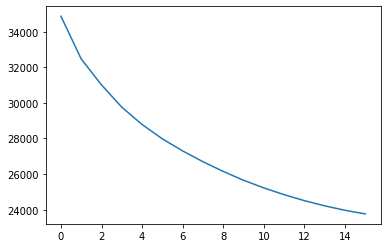

In [44]:
plt.plot(hist_entropia)
plt.show()

Predicción de algunos bigramas en el modelo

In [18]:
test_w = ['pues', 'por', 'par', 'en', 'otra']
print('Predicción de bigramas:')
for w in test_w:
    i_w = vocab[w]
    print(f'  {w} {inv_vocab[modelo.predecir(i_w)]}')

Predicción de bigramas:
  pues entonc
  por cad
  par que
  en el
  otra vez


### Paso 7. Probabilidad de oraciones.

Calcular la probabilidad de las siguientes oraciones:

- Nos bañamos con agua caliente
- El animalito le olía la cabeza
- Pascuala ordeñaba las vacas

In [21]:
oraciones_test = [
    "Nos bañamos con agua caliente",
    "El animalito le olía la cabeza",
    "Pascuala ordeñaba las vacas"
]
test_stems = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', oracion.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for oracion in oraciones_test
    ]

test_stems

[['nos', 'bañ', 'con', 'agu', 'calient'],
 ['el', 'animalit', 'le', 'oli', 'la', 'cabez'],
 ['pascual', 'ordeñ', 'las', 'vac']]

In [26]:
# Agrego BOS y EOS
test_stems = [[BOS, *oracion, EOS] for oracion in test_stems]
test_stems

[['<BOS>', 'nos', 'bañ', 'con', 'agu', 'calient', '<EOS>'],
 ['<BOS>', 'el', 'animalit', 'le', 'oli', 'la', 'cabez', '<EOS>'],
 ['<BOS>', 'pascual', 'ordeñ', 'las', 'vac', '<EOS>']]

Indexo las oraciones de prueba. Si la palabra queda fuera del vocabulario, le asigno el identificador <unk\>

In [54]:
i_UNK = vocab[UNK]
test_corpus_ids = [
    [
        vocab[stem] if vocab[stem]<N else i_UNK # Si la palabra es nueva, uso el indice de <unk>
        for stem in oracion
    ]
    for oracion in test_stems
]
test_corpus_ids

[[0, 93, 19, 80, 390, 34, 13],
 [0, 4, 465, 36, 34, 65, 311, 13],
 [0, 386, 34, 41, 207, 13]]

In [55]:
# Saco los bigramas
test_bigramas = [
    [bi for bi in zip(oracion[:-1], oracion[1:])]
    for oracion in test_corpus_ids
]
test_bigramas

[[(0, 93), (93, 19), (19, 80), (80, 390), (390, 34), (34, 13)],
 [(0, 4), (4, 465), (465, 36), (36, 34), (34, 65), (65, 311), (311, 13)],
 [(0, 386), (386, 34), (34, 41), (41, 207), (207, 13)]]

Calculo las probabilidades de las oraciones.

$$ p(w_1) \prod_{i=1} p(w_{i} | w_{i-1}) $$ 

In [56]:
def prob_lista_bigramas(lista_bi, A, Pi):
    prob = Pi[lista_bi[0][1]] # Primer bigrama de la lista, segunda palabra del bigrama
    for w_i, w_j in lista_bi:
        prob *= A[w_i, w_j]
    return prob

In [57]:
for lista_bi, oracion in zip(test_bigramas, oraciones_test):
    print(f'Probabilidad de \"{oracion}\" = {prob_lista_bigramas(lista_bi, matA, matPi)}')

Probabilidad de "Nos bañamos con agua caliente" = 8.090549504506798e-17
Probabilidad de "El animalito le olía la cabeza" = 3.968792773179962e-18
Probabilidad de "Pascuala ordeñaba las vacas" = 2.2842157046872043e-16
